<a href="https://colab.research.google.com/github/karp3890/U-Net-for-cityscapes-preprocessing/blob/main/U_NET_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>




# U-NET project by Jakub Karpiński


# Imports


In [1]:
%%sh
pip install  segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:

import datetime
import os.path
import sys
import csv 
import random
from tqdm import tqdm
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.python.keras.layers import Input
import cv2
from tensorflow.python.keras.layers import Dropout
import numpy as np
from tensorflow.python.keras.utils.all_utils import normalize
import glob
from tensorflow import constant
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.models import load_model
from tensorflow.python.keras.layers import Conv2D
from tensorflow.python.keras.layers import MaxPooling2D
from tensorflow.python.keras.layers import Conv2DTranspose
from tensorflow.python.keras.layers import concatenate
from tensorflow.python.keras.layers import Cropping2D
from tensorflow.keras.utils import to_categorical
from sklearn.utils import class_weight
from keras.metrics import OneHotMeanIoU
from keras.metrics import OneHotIoU
from keras.metrics import CategoricalAccuracy
from keras.metrics import CategoricalCrossentropy
from keras.metrics import MeanIoU
from tqdm import tqdm
from keras.layers import BatchNormalization
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.callbacks import CSVLogger
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping 
from tqdm import tqdm

import segmentation_models as sm
from sklearn.utils import class_weight
from segmentation_models.losses import  CategoricalFocalLoss
import tensorflow as tf

import keras

Segmentation Models: using `keras` framework.


# Constants


In [9]:


ARCHITECUTRE_NAME="21_CLASSES_UNET_SELF_WITH_BATCH_NORMALIZATION"
DATE=datetime.datetime.now().strftime("%d-%m-%y-%H:%M")
DEFAULT_TEST_SIZE: float = 0.1
CLASS_NUMBER: int = 21

#####LOSS############
focal_loss= CategoricalFocalLoss()
categorical_crossentropy = "categorical_crossentropy"
DEFAULT_LOSS: str =  focal_loss


def mean_iou():
  mean_iou = OneHotMeanIoU(CLASS_NUMBER,name="mean_iou")
  return mean_iou



def cateogrical_accuracy():
  categorical_accuracy = CategoricalAccuracy(name="categorical_accuracy")
  return categorical_accuracy

DEFAULT_METRICS = [cateogrical_accuracy()]


DEFAULT_EPOCHS_SIZE: int = 100 # number of epochs 
DEFAULT_BATCH_SIZE: int = 8 # number of images per gradient update
INPUT_HEIGHT: int = 256
INPUT_WIDTH: int = 256
OUTPUT_HEIGHT: int = 256
OUTPUT_WIDTH: int = 256
IMG_CHANNELS: int = 3

##########OPTIMIZER###############
#adam_01= keras.optimizers.adam_v2.Adam(learning_rate=0.01)


DEFAULT_OPTIMIZER ="adam"

######ACTIVATION######
ELU= "elu"
SELU = "selu"
RELU = "relu"
ACTIVATION_FUNCTION =  ELU
########################3#
KERNEL_INITIALIZER: str = "he_normal"  # wagi poczatkowe
PADDING: str = "valid"  # add paddding to the borders
KERNEL_SIZE = (3, 3)
POOLING = (2, 2)
STRIDES = (2, 2)
VALID = "valid"
SAME = "same"
CROP = (4, 4)
INPUT = Input((INPUT_HEIGHT, INPUT_WIDTH, IMG_CHANNELS))
INPUT_SHAPE = (INPUT_HEIGHT, INPUT_WIDTH, IMG_CHANNELS)
BASE_PATH=f"/content/drive/MyDrive/cnn_project/data/{ARCHITECUTRE_NAME}"
os.makedirs(BASE_PATH, exist_ok=True)
TRAIN_MASK_PATH = "/content/drive/MyDrive/cnn_project/data/input_masks_20_classes/train"
TRAIN_IMG_PATH = "/content/drive/MyDrive/cnn_project/data/input_images/train"
MODEL_PATH=f"{BASE_PATH}/models/{DATE}"
LOGS_PATH = f"{BASE_PATH}/logs/{DATE}"
MASK_MODE = 0
IMAGE_MODE = 1
IMG_NUMBER=1800





# Data preprocessing


Load and validate paths


In [3]:
def get_subsets(masks, images, test_size=DEFAULT_TEST_SIZE):
    subsets = train_test_split(masks, images, train_size=test_size)
    subsets_dict = {"masks_test": subsets[0],
                    "masks_train": subsets[1],
                    "image_test": subsets[2],
                    "image_train": subsets[3]
                    }
    print(f"MASK_TRAIN_SHAPE: {np.shape(subsets[1])}")    
    print(f"IMAGE_TRAIN_SHAPE: {np.shape(subsets[3])}")
    print(f"MASK_TEST_SHAPE: {np.shape(subsets[0])}")    
    print(f"IMAGE_TEST_SHAPE: {np.shape(subsets[2])}")        
    return subsets_dict
def prepare_paths(path,img_number):
    img_paths = []
    cities=os.listdir(path)
    for city in cities:
      data= glob.glob(f"{path}/{city}/*.png")
      data.sort()
      img_paths.append(data)
    img_paths = [item for sublist in img_paths for item in sublist]
    img_paths.sort()   
    return img_paths[0:img_number]
def validate_paths(img_paths,mask_paths,img_number):
  if(len(img_paths)==len(mask_paths)):
    rand=random.randint(0, len(img_paths)-1)
    print("VALIDATION\n")
    print(f"PATHS NUMBER:{len(img_paths)}\n")
    print(f"RANDOM IMG PATH:{img_paths[rand]}\n")
    print(f"RANDOM MASK PATH:{mask_paths[rand]}\n")
    img= cv2.imread(img_paths[rand])
    mask = cv2.imread(mask_paths[rand])
    plt.subplot(1,2,1)
    plt.imshow(img,cmap='jet')
    plt.title("IMG")
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap="jet")
    plt.title("MASK")    


def load_to_tensor(paths,mode):
  dataset=[]
  for path in tqdm(paths):
    img= cv2.imread(path,mode)
    dataset.append(img)
  dataset=np.array(dataset)
  print(f"SIZE OF DATASET: {np.shape(dataset)}") 
  return dataset

def validate_tensors(img_tensor,mask_tensor):
    rand=random.randint(0, len(img_tensor)-1)
    plt.subplot(1,2,1)
    plt.imshow(img_tensor[rand],cmap='jet')
    plt.title("IMG")
    plt.subplot(1,2,2)
    plt.imshow(mask_tensor[rand], cmap="jet")
    plt.title("MASK")

def label_encoder(dataset):
    label = LabelEncoder()
    dataset_original_shape =np.shape(dataset)
    dataset = dataset.reshape(-1, 1)
    dataset = label.fit_transform(dataset)
    dataset = dataset.reshape(dataset_original_shape)
    return dataset
def get_class_weights(dataset):
    label = LabelEncoder()
    dataset_original_shape = dataset.shape
    dataset = dataset.reshape(-1, 1)
    dataset = label.fit_transform(dataset)
    return dataset

def masks_to_categorical(mask_dataset):
    target_shape = np.shape(mask_dataset) + (CLASS_NUMBER,)
    print(f"Masks target shape: {target_shape}")
    mask_dataset = np.expand_dims(a=mask_dataset,axis=3)
    mask_dataset_categorical= to_categorical(y=mask_dataset, num_classes=CLASS_NUMBER,dtype="float32")
    mask_dataset_categorical_reshaped = np.reshape(mask_dataset_categorical, target_shape)
    return mask_dataset_categorical_reshaped

    

VALIDATION

PATHS NUMBER:1800

RANDOM IMG PATH:/content/drive/MyDrive/cnn_project/data/input_images/train/bremen/bremen_000100_000019_leftImg8bit.png

RANDOM MASK PATH:/content/drive/MyDrive/cnn_project/data/input_masks_20_classes/train/bremen/bremen_000100_000019_gtFine_labelTrainIds.png



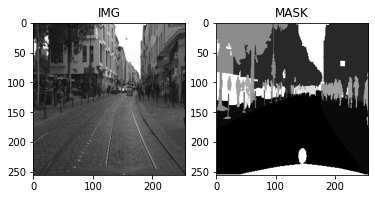

In [4]:
img_paths= prepare_paths(TRAIN_IMG_PATH,IMG_NUMBER)
mask_paths= prepare_paths(TRAIN_MASK_PATH,IMG_NUMBER)
validate_paths(img_paths,mask_paths,IMG_NUMBER)


 Load and validate tensors

100%|██████████| 1800/1800 [00:05<00:00, 342.05it/s]


SIZE OF DATASET: (1800, 256, 256)


100%|██████████| 1800/1800 [00:05<00:00, 310.44it/s]


SIZE OF DATASET: (1800, 256, 256, 3)


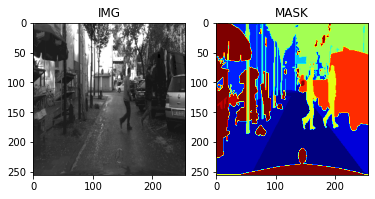

In [5]:
mask_tensor=load_to_tensor(mask_paths,MASK_MODE)
image_tensor = load_to_tensor(img_paths,IMAGE_MODE)
validate_tensors(image_tensor,mask_tensor)



Prepare masks

In [6]:
masks=label_encoder(mask_tensor)
masks= masks_to_categorical(masks)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Masks target shape: (1800, 256, 256, 21)


Prepare images

In [7]:
images = normalize(image_tensor, axis=1)

Split dataset

In [8]:
data = get_subsets(masks, images)


MASK_TRAIN_SHAPE: (1620, 256, 256, 21)
IMAGE_TRAIN_SHAPE: (1620, 256, 256, 3)
MASK_TEST_SHAPE: (180, 256, 256, 21)
IMAGE_TEST_SHAPE: (180, 256, 256, 3)


# LOGGING


CALLBACKS


In [10]:
logger= CSVLogger(f"{LOGS_PATH}/log.csv",separator=",", append=False)

check_point_weights = ModelCheckpoint(LOGS_PATH+"/checkpoint_data/weights/weights-improvement-{epoch:02d}.ckpt"
                             ,monitor='val_accuracy'
                             ,verbose=1
                            ,save_best_only=True
                            ,save_weights_only=True
                            ,mode='max')
early_stopping = EarlyStopping(monitor="val_mean_iou",
    min_delta=0.0001,
    patience=30,
    verbose=1,
    mode='max',
    baseline=None,
    restore_best_weights=True
)
    


CALLBACKS=[logger]#, early_stopping]



TRENING PARAMETERS


In [10]:
traning_data=[CLASS_NUMBER,DEFAULT_LOSS,DEFAULT_OPTIMIZER,DEFAULT_METRICS,DEFAULT_EPOCHS_SIZE,DEFAULT_BATCH_SIZE,ACTIVATION_FUNCTION,np.shape(images)[0],CALLBACKS]
column_names=["CLASS_NUMBER","DEFAULT_LOSS","DEFAULT_OPTIMIZER","DEFAULT_METRICS","DEFAULT_EPOCHS_SIZE","DEFAULT_BATCH_SIZE","ACTIVATION_FUNCTION","DATA_SIZE","CALLBACKS"]
os.makedirs(LOGS_PATH, exist_ok=True)
with open(f"{LOGS_PATH}/trening_parameters.csv" , 'w') as file:
  write = csv.writer(file)
  if(os.stat(f"{LOGS_PATH}/trening_parameters.csv").st_size==0):
      write.writerow(column_names)
  write.writerow(traning_data)


NameError: ignored

# MODELS

# UNET WITH RESNET34

In [ ]:
backbone="resnet34"
sm.set_framework('tf.keras')
sm.framework()
preprocess_input= sm.get_preprocessing(backbone)
data['image_train']= preprocess_input(data['image_train'])
data['image_test'] =  preprocess_input(data['image_test'])
print(np.shape(data['image_train']))
model=sm.Unet(backbone,encoder_weights="imagenet",classes=CLASS_NUMBER,activation="softmax")
model.compile(optimizer=DEFAULT_OPTIMIZER
              ,loss=DEFAULT_LOSS
              ,metrics = DEFAULT_METRICS)
model.summary()

zamrozic wartswy resnetu 

SyntaxError: ignored

# UNET WIH VGG16

In [ ]:
backbone="vgg16"

sm.set_framework('tf.keras')
focal_loss = sm.losses.CategoricalFocalLoss()


sm.framework()
preprocess_input= sm.get_preprocessing(backbone)
data['image_train']= preprocess_input(data['image_train'])
data['image_test'] =  preprocess_input(data['image_test'])
print(np.shape(data['image_train']))
model=sm.Unet(backbone,encoder_weights="imagenet",classes=CLASS_NUMBER,activation="softmax")
model.compile(optimizer=DEFAULT_OPTIMIZER
              ,loss=focal_loss
              ,metrics = DEFAULT_METRICS)
model.summary()

# U-NET MODEL 256X256 WITH BATCH NORMALIZATION

In [11]:
def unet_256x256_with_dropout_and_batch_norm(input):
  ########FIRST_ENCODER##############
  conv_1=Conv2D(32,KERNEL_SIZE,activation=ACTIVATION_FUNCTION,kernel_initializer=KERNEL_INITIALIZER, padding=SAME)(input)
  # conv_1= Dropout(0.1)(conv_1)
  conv_1= tf.keras.layers.BatchNormalization()(conv_1)
  conv_1=Conv2D(32,KERNEL_SIZE,activation=ACTIVATION_FUNCTION,kernel_initializer=KERNEL_INITIALIZER, padding=SAME)(conv_1)
  pool_1= MaxPooling2D(POOLING)(conv_1)
  ########SECOND_ENCODER##############
  conv_2=Conv2D(64,KERNEL_SIZE,activation=ACTIVATION_FUNCTION,kernel_initializer=KERNEL_INITIALIZER, padding=SAME)(pool_1)
  # conv_2=Dropout(0.2)(conv_2)
  conv_2=tf.keras.layers.BatchNormalization()(conv_2)
  conv_2=Conv2D(64,KERNEL_SIZE,activation=ACTIVATION_FUNCTION,kernel_initializer=KERNEL_INITIALIZER, padding=SAME)(conv_2)
  pool_2=MaxPooling2D(POOLING)(conv_2)
  ########THIRD_ENCODER##############
  conv_3=Conv2D(128,KERNEL_SIZE,activation=ACTIVATION_FUNCTION,kernel_initializer=KERNEL_INITIALIZER, padding=SAME)(pool_2)
  # conv_3=Dropout(0.3)(conv_3)
  conv_3=tf.keras.layers.BatchNormalization()(conv_3)
  conv_3=Conv2D(128,KERNEL_SIZE,activation=ACTIVATION_FUNCTION,kernel_initializer=KERNEL_INITIALIZER, padding=SAME)(conv_3)
  pool_3 = MaxPooling2D(POOLING)(conv_3)
  ########FOURTH_ENCODER##############
  conv_4=Conv2D(256,KERNEL_SIZE,activation=ACTIVATION_FUNCTION,kernel_initializer=KERNEL_INITIALIZER, padding=SAME)(pool_3)

  # conv_4=Dropout(0.4)(conv_4)
  conv_4=tf.keras.layers.BatchNormalization()(conv_4)

  conv_4=Conv2D(256,KERNEL_SIZE,activation=ACTIVATION_FUNCTION,kernel_initializer=KERNEL_INITIALIZER, padding=SAME)(conv_4)
  pool_4=MaxPooling2D(POOLING)(conv_4)
  ########FIFTH_ENCODER##############
  conv_5=Conv2D(512,KERNEL_SIZE,activation=ACTIVATION_FUNCTION,kernel_initializer=KERNEL_INITIALIZER, padding=SAME)(pool_4)
  # conv_5=Dropout(0.4)(conv_5)
  conv_5=tf.keras.layers.BatchNormalization()(conv_5)
  conv_5=Conv2D(512,KERNEL_SIZE,activation=ACTIVATION_FUNCTION,kernel_initializer=KERNEL_INITIALIZER, padding=SAME)(conv_5)
  pool_5=MaxPooling2D(POOLING)(conv_5)
  ########MIDDLE##############
  middle = Conv2D(1024,KERNEL_SIZE,activation=ACTIVATION_FUNCTION,kernel_initializer=KERNEL_INITIALIZER, padding=SAME)(pool_5)
  # middle=Dropout(0.5)(middle)
  middle=tf.keras.layers.BatchNormalization()(middle)
  middle =  Conv2D(1024,KERNEL_SIZE,activation=ACTIVATION_FUNCTION,kernel_initializer=KERNEL_INITIALIZER, padding=SAME)(middle)
  ########FIRST_DECODER##############
  up_conv_6= Conv2DTranspose(512,KERNEL_SIZE,strides=(2,2),padding=SAME)(middle)
  up_conv_6= concatenate([up_conv_6,conv_5])
  conv_6=Conv2D(512,KERNEL_SIZE,activation=ACTIVATION_FUNCTION,kernel_initializer=KERNEL_INITIALIZER, padding=SAME)(up_conv_6)

  # conv_6=Dropout(0.4)(conv_6)
  conv_6=tf.keras.layers.BatchNormalization()(conv_6)

  conv_6=Conv2D(512,KERNEL_SIZE,activation=ACTIVATION_FUNCTION,kernel_initializer=KERNEL_INITIALIZER, padding=SAME)(conv_6)
  up_conv_7= Conv2DTranspose(256,KERNEL_SIZE,strides=(2,2),padding=SAME)(conv_6)
  up_conv_7 = concatenate([up_conv_7,conv_4])
  conv_7=Conv2D(256,KERNEL_SIZE,activation=ACTIVATION_FUNCTION,kernel_initializer=KERNEL_INITIALIZER, padding=SAME)(up_conv_7)

  # conv_7=Dropout(0.4)(conv_7)
  conv_7=tf.keras.layers.BatchNormalization()(conv_7)

  conv_7=Conv2D(256,KERNEL_SIZE,activation=ACTIVATION_FUNCTION,kernel_initializer=KERNEL_INITIALIZER, padding=SAME)(conv_7)
  up_conv_8=  Conv2DTranspose(128,KERNEL_SIZE,strides=(2,2),padding=SAME)(conv_7)
  up_conv_8 = concatenate([up_conv_8,conv_3])
  conv_8=Conv2D(128,KERNEL_SIZE,activation=ACTIVATION_FUNCTION,kernel_initializer=KERNEL_INITIALIZER, padding=SAME)(up_conv_8)


  # conv_8=Dropout(0.3)(conv_8)
  conv_8=tf.keras.layers.BatchNormalization()(conv_8)


  conv_8=Conv2D(128,KERNEL_SIZE,activation=ACTIVATION_FUNCTION,kernel_initializer=KERNEL_INITIALIZER, padding=SAME)(conv_8)
  up_conv_9 =  Conv2DTranspose(64,KERNEL_SIZE,strides=(2,2),padding=SAME)(conv_8)
  up_conv_9 = concatenate([up_conv_9,conv_2])
  conv_9 = Conv2D(64,KERNEL_SIZE,activation=ACTIVATION_FUNCTION,kernel_initializer=KERNEL_INITIALIZER, padding=SAME)(up_conv_9)

  # conv_9=Dropout(0.2)(conv_9)
  conv_9=tf.keras.layers.BatchNormalization()(conv_9)

  conv_9 = Conv2D(64,KERNEL_SIZE,activation=ACTIVATION_FUNCTION,kernel_initializer=KERNEL_INITIALIZER, padding=SAME)(conv_9)
  up_conv_10 = Conv2DTranspose(32,KERNEL_SIZE,strides=(2,2),padding=SAME)(conv_9) 
  up_conv_10 = concatenate([up_conv_10,conv_1])
  conv_10 = Conv2D(32,KERNEL_SIZE,activation=ACTIVATION_FUNCTION,kernel_initializer=KERNEL_INITIALIZER, padding=SAME)(up_conv_10)
  # conv_10=Dropout(0.1)(conv_10)
  conv_10=tf.keras.layers.BatchNormalization()(conv_10)
  conv_10 = Conv2D(32,KERNEL_SIZE,activation=ACTIVATION_FUNCTION,kernel_initializer=KERNEL_INITIALIZER, padding=SAME)(conv_10)
  output_layer= Conv2D(CLASS_NUMBER,(1,1), activation="softmax")(conv_10)
  return  output_layer

model = Model(inputs=[INPUT], outputs = [unet_256x256_with_dropout_and_batch_norm(INPUT)])
model.compile(optimizer=DEFAULT_OPTIMIZER
              ,loss=DEFAULT_LOSS
              ,metrics = DEFAULT_METRICS)
model.summary()


The following Variables were used a Lambda layer's call (tf.compat.v1.nn.fused_batch_norm), but
are not present in its tracked objects:
  <tf.Variable 'batch_normalization/gamma:0' shape=(32,) dtype=float32>
  <tf.Variable 'batch_normalization/beta:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.compat.v1.nn.fused_batch_norm_1), but
are not present in its tracked objects:
  <tf.Variable 'batch_normalization_1/gamma:0' shape=(64,) dtype=float32>
  <tf.Variable 'batch_normalization_1/beta:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input_2[0][0]                    
__________________________________________________________________________________________________
tf.compat.v1.nn.fused_batch_nor ((None, 256, 256, 32 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 9248        tf.compat.v1.nn.fused_batch_norm[
______________________________________________________________________________________________

# U-NET MODEL 256X256 WITH DROPOUT

In [ ]:

def unet_256x256_with_dropout_and_batch_norm(input):
  ########FIRST_ENCODER##############
  conv_1=Conv2D(32,KERNEL_SIZE,activation=ACTIVATION_FUNCTION,kernel_initializer=KERNEL_INITIALIZER, padding=SAME)(input)
  # conv_1= Dropout(0.1)(conv_1)
  conv_1=BatchNormalization()(conv_1)
  conv_1=Conv2D(32,KERNEL_SIZE,activation=ACTIVATION_FUNCTION,kernel_initializer=KERNEL_INITIALIZER, padding=SAME)(conv_1)
  pool_1= MaxPooling2D(POOLING)(conv_1)
  ########SECOND_ENCODER##############
  conv_2=Conv2D(64,KERNEL_SIZE,activation=ACTIVATION_FUNCTION,kernel_initializer=KERNEL_INITIALIZER, padding=SAME)(pool_1)
  # conv_2=Dropout(0.2)(conv_2)
  conv_2=BatchNormalization()(conv_2)
  conv_2=Conv2D(64,KERNEL_SIZE,activation=ACTIVATION_FUNCTION,kernel_initializer=KERNEL_INITIALIZER, padding=SAME)(conv_2)
  pool_2=MaxPooling2D(POOLING)(conv_2)
  ########THIRD_ENCODER##############
  conv_3=Conv2D(128,KERNEL_SIZE,activation=ACTIVATION_FUNCTION,kernel_initializer=KERNEL_INITIALIZER, padding=SAME)(pool_2)
  # conv_3=Dropout(0.3)(conv_3)
  conv_3=BatchNormalization()(conv_3)
  conv_3=Conv2D(128,KERNEL_SIZE,activation=ACTIVATION_FUNCTION,kernel_initializer=KERNEL_INITIALIZER, padding=SAME)(conv_3)
  pool_3 = MaxPooling2D(POOLING)(conv_3)
  ########FOURTH_ENCODER##############
  conv_4=Conv2D(256,KERNEL_SIZE,activation=ACTIVATION_FUNCTION,kernel_initializer=KERNEL_INITIALIZER, padding=SAME)(pool_3)

  # conv_4=Dropout(0.4)(conv_4)
  conv_4=BatchNormalization()(conv_4)

  conv_4=Conv2D(256,KERNEL_SIZE,activation=ACTIVATION_FUNCTION,kernel_initializer=KERNEL_INITIALIZER, padding=SAME)(conv_4)
  pool_4=MaxPooling2D(POOLING)(conv_4)
  ########FIFTH_ENCODER##############
  conv_5=Conv2D(512,KERNEL_SIZE,activation=ACTIVATION_FUNCTION,kernel_initializer=KERNEL_INITIALIZER, padding=SAME)(pool_4)
  # conv_5=Dropout(0.4)(conv_5)
  conv_5=BatchNormalization()(conv_5)
  conv_5=Conv2D(512,KERNEL_SIZE,activation=ACTIVATION_FUNCTION,kernel_initializer=KERNEL_INITIALIZER, padding=SAME)(conv_5)
  pool_5=MaxPooling2D(POOLING)(conv_5)
  ########MIDDLE##############
  middle = Conv2D(1024,KERNEL_SIZE,activation=ACTIVATION_FUNCTION,kernel_initializer=KERNEL_INITIALIZER, padding=SAME)(pool_5)
  # middle=Dropout(0.5)(middle)
  middle=BatchNormalization()(middle)
  middle =  Conv2D(1024,KERNEL_SIZE,activation=ACTIVATION_FUNCTION,kernel_initializer=KERNEL_INITIALIZER, padding=SAME)(middle)
  ########FIRST_DECODER##############
  up_conv_6= Conv2DTranspose(512,KERNEL_SIZE,strides=(2,2),padding=SAME)(middle)
  up_conv_6= concatenate([up_conv_6,conv_5])
  conv_6=Conv2D(512,KERNEL_SIZE,activation=ACTIVATION_FUNCTION,kernel_initializer=KERNEL_INITIALIZER, padding=SAME)(up_conv_6)

  # conv_6=Dropout(0.4)(conv_6)
  conv_6=BatchNormalization()(conv_6)

  conv_6=Conv2D(512,KERNEL_SIZE,activation=ACTIVATION_FUNCTION,kernel_initializer=KERNEL_INITIALIZER, padding=SAME)(conv_6)
  up_conv_7= Conv2DTranspose(256,KERNEL_SIZE,strides=(2,2),padding=SAME)(conv_6)
  up_conv_7 = concatenate([up_conv_7,conv_4])
  conv_7=Conv2D(256,KERNEL_SIZE,activation=ACTIVATION_FUNCTION,kernel_initializer=KERNEL_INITIALIZER, padding=SAME)(up_conv_7)

  # conv_7=Dropout(0.4)(conv_7)
  conv_7=BatchNormalization()(conv_7)

  conv_7=Conv2D(256,KERNEL_SIZE,activation=ACTIVATION_FUNCTION,kernel_initializer=KERNEL_INITIALIZER, padding=SAME)(conv_7)
  up_conv_8=  Conv2DTranspose(128,KERNEL_SIZE,strides=(2,2),padding=SAME)(conv_7)
  up_conv_8 = concatenate([up_conv_8,conv_3])
  conv_8=Conv2D(128,KERNEL_SIZE,activation=ACTIVATION_FUNCTION,kernel_initializer=KERNEL_INITIALIZER, padding=SAME)(up_conv_8)


  # conv_8=Dropout(0.3)(conv_8)
  conv_8=BatchNormalization()(conv_8)


  conv_8=Conv2D(128,KERNEL_SIZE,activation=ACTIVATION_FUNCTION,kernel_initializer=KERNEL_INITIALIZER, padding=SAME)(conv_8)
  up_conv_9 =  Conv2DTranspose(64,KERNEL_SIZE,strides=(2,2),padding=SAME)(conv_8)
  up_conv_9 = concatenate([up_conv_9,conv_2])
  conv_9 = Conv2D(64,KERNEL_SIZE,activation=ACTIVATION_FUNCTION,kernel_initializer=KERNEL_INITIALIZER, padding=SAME)(up_conv_9)

  # conv_9=Dropout(0.2)(conv_9)
  conv_9=BatchNormalization()(conv_9)

  conv_9 = Conv2D(64,KERNEL_SIZE,activation=ACTIVATION_FUNCTION,kernel_initializer=KERNEL_INITIALIZER, padding=SAME)(conv_9)
  up_conv_10 = Conv2DTranspose(32,KERNEL_SIZE,strides=(2,2),padding=SAME)(conv_9) 
  up_conv_10 = concatenate([up_conv_10,conv_1])
  conv_10 = Conv2D(32,KERNEL_SIZE,activation=ACTIVATION_FUNCTION,kernel_initializer=KERNEL_INITIALIZER, padding=SAME)(up_conv_10)
  # conv_10=Dropout(0.1)(conv_10)
  conv_10=BatchNormalization()(conv_10)
  conv_10 = Conv2D(32,KERNEL_SIZE,activation=ACTIVATION_FUNCTION,kernel_initializer=KERNEL_INITIALIZER, padding=SAME)(conv_10)
  output_layer= Conv2D(CLASS_NUMBER,(1,1), activation="softmax")(conv_10)
  return  output_layer

model = Model(inputs=[INPUT], outputs = [unet_256x256_with_dropout_and_batch_norm(INPUT)])
model.compile(DEFAULT_OPTIMIZER
              ,loss=DEFAULT_LOSS
              ,metrics = DEFAULT_METRICS)
model.summary()


The following Variables were used a Lambda layer's call (tf.compat.v1.nn.fused_batch_norm), but
are not present in its tracked objects:
  <tf.Variable 'batch_normalization/gamma:0' shape=(32,) dtype=float32>
  <tf.Variable 'batch_normalization/beta:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.compat.v1.nn.fused_batch_norm_1), but
are not present in its tracked objects:
  <tf.Variable 'batch_normalization_1/gamma:0' shape=(64,) dtype=float32>
  <tf.Variable 'batch_normalization_1/beta:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda

ValueError: ignored

# U-NET Model 256X256 WITHOUT DROPOUT

In [ ]:
def unet_256x256(input):
  ########FIRST_ENCODER##############
  conv_1=Conv2D(32,KERNEL_SIZE,activation=ACTIVATION_FUNCTION,kernel_initializer=KERNEL_INITIALIZER, padding=SAME)(input)
  conv_1=Conv2D(32,KERNEL_SIZE,activation=ACTIVATION_FUNCTION,kernel_initializer=KERNEL_INITIALIZER, padding=SAME)(conv_1)
  pool_1= MaxPooling2D(POOLING)(conv_1)
  ########SECOND_ENCODER##############
  conv_2=Conv2D(64,KERNEL_SIZE,activation=ACTIVATION_FUNCTION,kernel_initializer=KERNEL_INITIALIZER, padding=SAME)(pool_1)
  conv_2=Conv2D(64,KERNEL_SIZE,activation=ACTIVATION_FUNCTION,kernel_initializer=KERNEL_INITIALIZER, padding=SAME)(conv_2)
  pool_2=MaxPooling2D(POOLING)(conv_2)
  ########THIRD_ENCODER##############
  conv_3=Conv2D(128,KERNEL_SIZE,activation=ACTIVATION_FUNCTION,kernel_initializer=KERNEL_INITIALIZER, padding=SAME)(pool_2)
  conv_3=Conv2D(128,KERNEL_SIZE,activation=ACTIVATION_FUNCTION,kernel_initializer=KERNEL_INITIALIZER, padding=SAME)(conv_3)
  pool_3 = MaxPooling2D(POOLING)(conv_3)
  ########FOURTH_ENCODER##############
  conv_4=Conv2D(256,KERNEL_SIZE,activation=ACTIVATION_FUNCTION,kernel_initializer=KERNEL_INITIALIZER, padding=SAME)(pool_3)
  conv_4=Conv2D(256,KERNEL_SIZE,activation=ACTIVATION_FUNCTION,kernel_initializer=KERNEL_INITIALIZER, padding=SAME)(conv_4)
  pool_4=MaxPooling2D(POOLING)(conv_4)
  ########FIFTH_ENCODER##############
  conv_5=Conv2D(512,KERNEL_SIZE,activation=ACTIVATION_FUNCTION,kernel_initializer=KERNEL_INITIALIZER, padding=SAME)(pool_4)
  conv_5=Conv2D(512,KERNEL_SIZE,activation=ACTIVATION_FUNCTION,kernel_initializer=KERNEL_INITIALIZER, padding=SAME)(conv_5)
  pool_5=MaxPooling2D(POOLING)(conv_5)
  ########MIDDLE##############
  middle = Conv2D(1024,KERNEL_SIZE,activation=ACTIVATION_FUNCTION,kernel_initializer=KERNEL_INITIALIZER, padding=SAME)(pool_5)
  middle =  Conv2D(1024,KERNEL_SIZE,activation=ACTIVATION_FUNCTION,kernel_initializer=KERNEL_INITIALIZER, padding=SAME)(middle)
  ########FIRST_DECODER##############
  up_conv_6= Conv2DTranspose(512,KERNEL_SIZE,strides=(2,2),padding=SAME)(middle)
  up_conv_6= concatenate([up_conv_6,conv_5])
  conv_6=Conv2D(512,KERNEL_SIZE,activation=ACTIVATION_FUNCTION,kernel_initializer=KERNEL_INITIALIZER, padding=SAME)(up_conv_6)
  conv_6=Conv2D(512,KERNEL_SIZE,activation=ACTIVATION_FUNCTION,kernel_initializer=KERNEL_INITIALIZER, padding=SAME)(conv_6)
  up_conv_7= Conv2DTranspose(256,KERNEL_SIZE,strides=(2,2),padding=SAME)(conv_6)
  up_conv_7 = concatenate([up_conv_7,conv_4])
  conv_7=Conv2D(256,KERNEL_SIZE,activation=ACTIVATION_FUNCTION,kernel_initializer=KERNEL_INITIALIZER, padding=SAME)(up_conv_7)
  conv_7=Conv2D(256,KERNEL_SIZE,activation=ACTIVATION_FUNCTION,kernel_initializer=KERNEL_INITIALIZER, padding=SAME)(conv_7)
  up_conv_8=  Conv2DTranspose(128,KERNEL_SIZE,strides=(2,2),padding=SAME)(conv_7)
  up_conv_8 = concatenate([up_conv_8,conv_3])
  conv_8=Conv2D(128,KERNEL_SIZE,activation=ACTIVATION_FUNCTION,kernel_initializer=KERNEL_INITIALIZER, padding=SAME)(up_conv_8)
  conv_8=Conv2D(128,KERNEL_SIZE,activation=ACTIVATION_FUNCTION,kernel_initializer=KERNEL_INITIALIZER, padding=SAME)(conv_8)
  up_conv_9 =  Conv2DTranspose(64,KERNEL_SIZE,strides=(2,2),padding=SAME)(conv_8)
  up_conv_9 = concatenate([up_conv_9,conv_2])
  conv_9 = Conv2D(64,KERNEL_SIZE,activation=ACTIVATION_FUNCTION,kernel_initializer=KERNEL_INITIALIZER, padding=SAME)(up_conv_9)
  conv_9 = Conv2D(64,KERNEL_SIZE,activation=ACTIVATION_FUNCTION,kernel_initializer=KERNEL_INITIALIZER, padding=SAME)(conv_9)
  up_conv_10 = Conv2DTranspose(32,KERNEL_SIZE,strides=(2,2),padding=SAME)(conv_9) 
  up_conv_10 = concatenate([up_conv_10,conv_1])
  conv_10 = Conv2D(32,KERNEL_SIZE,activation=ACTIVATION_FUNCTION,kernel_initializer=KERNEL_INITIALIZER, padding=SAME)(up_conv_10)
  conv_10 = Conv2D(32,KERNEL_SIZE,activation=ACTIVATION_FUNCTION,kernel_initializer=KERNEL_INITIALIZER, padding=SAME)(conv_10)
  output_layer= Conv2D(CLASS_NUMBER,(1,1), activation="softmax")(conv_10)
  return  output_layer

model = Model(inputs=[INPUT], outputs = [unet_256x256(INPUT)])
model.compile(optimizer="adam"
              ,loss=DEFAULT_LOSS
              ,metrics = DEFAULT_METRICS)
model.summary()


Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_253 (Conv2D)             (None, 256, 256, 32) 896         input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_254 (Conv2D)             (None, 256, 256, 32) 9248        conv2d_253[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_55 (MaxPooling2D) (None, 128, 128, 32) 0           conv2d_254[0][0]                 
___________________________________________________________________________________________

# U-NET Model 572x572 WITH DROPOUT

In [ ]:
def unet_model(input):
    first_encoder_layer = double_conv(64, input, VALID, "FIRST_ENCODER_LAYER",0.1)
    second_encoder_layer = conv_and_d_pool_step(128, first_encoder_layer, VALID, 0.1,"SECOND_ENCODER_LAYER")
    third_encoder_layer = conv_and_d_pool_step(256, second_encoder_layer, VALID, 0.2,"THIRD_ENCODER_LAYER")
    fourth_encoder_layer = conv_and_d_pool_step(512, third_encoder_layer, VALID,0.2, "FOURTH_ENCODER_LAYER")
    middle_layer = conv_and_d_pool_step(1024, fourth_encoder_layer, VALID, 0.3,"MIDDLE_LAYER")
    fourth_decoder_layer = m_pool_con_conv_step(512, middle_layer, fourth_encoder_layer, SAME, (4, 4), 0.2,
                                                     "FOURTH_DECODER_LAYER")
    third_decoder_layer = m_pool_con_conv_step(256, fourth_decoder_layer, third_encoder_layer, SAME, (16, 16),0.2,
                                                    "THIRD_DECODER_LAYER")
    second_decoder_layer = m_pool_con_conv_step(128, third_decoder_layer, second_encoder_layer, SAME, (40, 40),0.1,
                                                     "SECOND_DECODER_LAYER")
    first_decoder_layer = m_pool_con_conv_step(64, second_decoder_layer, first_encoder_layer, SAME, (88, 88),0.1,
                                                    "FIRST_DECODER_LAYER")
    output_layer = Conv2D(CLASS_NUMBER, (1, 1), activation="softmax",
                          kernel_initializer=KERNEL_INITIALIZER, padding=PADDING)(first_decoder_layer)
    print(f"OUPUT shape after:\n {output_layer.shape}")
    return output_layer

def conv_and_d_pool_step(depth, input_layer, padding, dropout_factor, name):
    max_pooling_layer = MaxPooling2D(POOLING)(input_layer)
    print(f"{name} shape after max pooling:\n{max_pooling_layer.shape}")
    convolution_layer = Conv2D(filters=depth, kernel_size=KERNEL_SIZE, activation=ACTIVATION_FUNCTION,
                               kernel_initializer=KERNEL_INITIALIZER, padding=padding)(max_pooling_layer)
    convolution_layer= Dropout(dropout_factor)(convolution_layer)                           
    print(f"{name} shape after 1st convolution:\n {convolution_layer.shape}")
    output_layer = Conv2D(filters=depth, kernel_size=KERNEL_SIZE, activation=ACTIVATION_FUNCTION,
                          kernel_initializer=KERNEL_INITIALIZER, padding=padding)(convolution_layer)

    print(f"{name} shape after 2nd convolution:\n {output_layer.shape}")
    return output_layer

def m_pool_con_conv_step(depth, input_layer, encoder_layer, padding, crop,dropout_factor, name):
    down_pool_layer = Conv2DTranspose(depth, KERNEL_SIZE, strides=STRIDES, padding=padding)(input_layer)
    print(f"{name} shape after DOWN pooling:\n{down_pool_layer.shape}")
    print(down_pool_layer.shape)
    encoder_layer = Cropping2D(crop)(encoder_layer)
    concatenation_layer = concatenate([down_pool_layer, encoder_layer])
    print(f"{name} shape after concatenation:\n {concatenation_layer.shape}")
    convolution_layer = Conv2D(depth, KERNEL_SIZE, activation=ACTIVATION_FUNCTION,
                               kernel_initializer=KERNEL_INITIALIZER, padding=PADDING)(concatenation_layer)
    convolution_layer =   Dropout(dropout_factor)(convolution_layer)                           
    print(f"{name} shape after 1st convolution:\n {convolution_layer.shape}")
    output_layer = Conv2D(depth, KERNEL_SIZE, activation=ACTIVATION_FUNCTION, kernel_initializer=KERNEL_INITIALIZER,
                          padding=PADDING)(convolution_layer)
    print(f"{name} shape after 2nd convolution:\n {output_layer.shape}")
    return output_layer

def double_conv(depth, input_layer, padding, name,dropout_factor):
    convolution_layer = Conv2D(depth, KERNEL_SIZE, activation=ACTIVATION_FUNCTION,
                               kernel_initializer=KERNEL_INITIALIZER,
                               padding=PADDING)(input_layer)

    convolution_layer =  Dropout(dropout_factor)(convolution_layer)
    print(f"{name} shape after 1st convolution:\n {convolution_layer.shape}")
    output_layer = Conv2D(depth, KERNEL_SIZE, activation=ACTIVATION_FUNCTION, kernel_initializer=KERNEL_INITIALIZER,
                          padding=PADDING)(convolution_layer)
    print(f"{name} shape after 2nd convolution: \n {output_layer.shape}")
    return output_layer
model = Model(inputs=[INPUT], outputs = [unet_model(INPUT)])
model.compile(optimizer=DEFAULT_OPTIMIZER
              ,loss=DEFAULT_LOSS
              ,metrics = DEFAULT_METRICS)
model.summary()

# U-NET Model 572x572 WITHOUT DROPOUT


In [ ]:


def unet_model(input):
    first_encoder_layer = double_conv(64, input, VALID, "FIRST_ENCODER_LAYER")
    second_encoder_layer = conv_and_d_pool_step(128, first_encoder_layer, VALID, "SECOND_ENCODER_LAYER")
    third_encoder_layer = conv_and_d_pool_step(256, second_encoder_layer, VALID, "THIRD_ENCODER_LAYER")
    fourth_encoder_layer = conv_and_d_pool_step(512, third_encoder_layer, VALID, "FOURTH_ENCODER_LAYER")
    middle_layer = conv_and_d_pool_step(1024, fourth_encoder_layer, VALID, "MIDDLE_LAYER")
    fourth_decoder_layer = m_pool_con_conv_step(512, middle_layer, fourth_encoder_layer, SAME, (4, 4),
                                                     "FOURTH_DECODER_LAYER")
    third_decoder_layer = m_pool_con_conv_step(256, fourth_decoder_layer, third_encoder_layer, SAME, (16, 16),
                                                    "THIRD_DECODER_LAYER")
    second_decoder_layer = m_pool_con_conv_step(128, third_decoder_layer, second_encoder_layer, SAME, (40, 40),
                                                     "SECOND_DECODER_LAYER")
    first_decoder_layer = m_pool_con_conv_step(64, second_decoder_layer, first_encoder_layer, SAME, (88, 88),
                                                    "FIRST_DECODER_LAYER")
    output_layer = Conv2D(CLASS_NUMBER, (1, 1), activation="softmax",
                          kernel_initializer=KERNEL_INITIALIZER, padding=PADDING)(first_decoder_layer)
    print(f"OUPUT shape after:\n {output_layer.shape}")
    return output_layer

def conv_and_d_pool_step(depth, input_layer, padding, name):
    max_pooling_layer = MaxPooling2D(POOLING)(input_layer)
    print(f"{name} shape after max pooling:\n{max_pooling_layer.shape}")
    convolution_layer = Conv2D(filters=depth, kernel_size=KERNEL_SIZE, activation=ACTIVATION_FUNCTION,
                               kernel_initializer=KERNEL_INITIALIZER, padding=padding)(max_pooling_layer)
    print(f"{name} shape after 1st convolution:\n {convolution_layer.shape}")
    output_layer = Conv2D(filters=depth, kernel_size=KERNEL_SIZE, activation=ACTIVATION_FUNCTION,
                          kernel_initializer=KERNEL_INITIALIZER, padding=padding)(convolution_layer)

    print(f"{name} shape after 2nd convolution:\n {output_layer.shape}")
    return output_layer

def m_pool_con_conv_step(depth, input_layer, encoder_layer, padding, crop, name):
    down_pool_layer = Conv2DTranspose(depth, KERNEL_SIZE, strides=STRIDES, padding=padding)(input_layer)
    print(f"{name} shape after DOWN pooling:\n{down_pool_layer.shape}")
    print(down_pool_layer.shape)
    encoder_layer = Cropping2D(crop)(encoder_layer)
    concatenation_layer = concatenate([down_pool_layer, encoder_layer])
    print(f"{name} shape after concatenation:\n {concatenation_layer.shape}")
    convolution_layer = Conv2D(depth, KERNEL_SIZE, activation=ACTIVATION_FUNCTION,
                               kernel_initializer=KERNEL_INITIALIZER, padding=PADDING)(concatenation_layer)
    print(f"{name} shape after 1st convolution:\n {convolution_layer.shape}")
    output_layer = Conv2D(depth, KERNEL_SIZE, activation=ACTIVATION_FUNCTION, kernel_initializer=KERNEL_INITIALIZER,
                          padding=PADDING)(convolution_layer)
    print(f"{name} shape after 2nd convolution:\n {output_layer.shape}")
    return output_layer

def double_conv(depth, input_layer, padding, name):
    convolution_layer = Conv2D(depth, KERNEL_SIZE, activation=ACTIVATION_FUNCTION,
                               kernel_initializer=KERNEL_INITIALIZER,
                               padding=PADDING)(input_layer)
    
    print(f"{name} shape after 1st convolution:\n {convolution_layer.shape}")
    output_layer = Conv2D(depth, KERNEL_SIZE, activation=ACTIVATION_FUNCTION, kernel_initializer=KERNEL_INITIALIZER,
                          padding=PADDING)(convolution_layer)
    print(f"{name} shape after 2nd convolution: \n {output_layer.shape}")
    return output_layer
model = Model(inputs=[INPUT], outputs = [unet_model(INPUT)])
model.compile(optimizer=DEFAULT_OPTIMIZER
              ,loss=DEFAULT_LOSS
              ,metrics = DEFAULT_METRICS)
model.summary()

FIRST_ENCODER_LAYER shape after 1st convolution:
 (None, 254, 254, 64)
FIRST_ENCODER_LAYER shape after 2nd convolution: 
 (None, 252, 252, 64)
SECOND_ENCODER_LAYER shape after max pooling:
(None, 126, 126, 64)
SECOND_ENCODER_LAYER shape after 1st convolution:
 (None, 124, 124, 128)
SECOND_ENCODER_LAYER shape after 2nd convolution:
 (None, 122, 122, 128)
THIRD_ENCODER_LAYER shape after max pooling:
(None, 61, 61, 128)
THIRD_ENCODER_LAYER shape after 1st convolution:
 (None, 59, 59, 256)
THIRD_ENCODER_LAYER shape after 2nd convolution:
 (None, 57, 57, 256)
FOURTH_ENCODER_LAYER shape after max pooling:
(None, 28, 28, 256)
FOURTH_ENCODER_LAYER shape after 1st convolution:
 (None, 26, 26, 512)
FOURTH_ENCODER_LAYER shape after 2nd convolution:
 (None, 24, 24, 512)
MIDDLE_LAYER shape after max pooling:
(None, 12, 12, 512)
MIDDLE_LAYER shape after 1st convolution:
 (None, 10, 10, 1024)
MIDDLE_LAYER shape after 2nd convolution:
 (None, 8, 8, 1024)
FOURTH_DECODER_LAYER shape after DOWN pooling:


ValueError: ignored




# Trening


MODEL EVALUATION UTIL FUNCTIONS


In [12]:
def display_and_save_metrics(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(loss) + 1)

  figure= plt.figure(figsize=(20,10))
  plt.subplot(1,2,1)
  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  # cat_acc = history.history['categorical_accuracy']
  # val_cat_acc = history.history['val_categorical_accuracy']
  # plt.subplot(1,2,2)
  # plt.plot(epochs, cat_acc, 'b', label='Training Categorical Accuracy')
  # plt.plot(epochs, val_cat_acc, 'r', label='Validation Categorical Accuracy')
  # plt.title('Training and validation Categorical Accuracy')
  # plt.xlabel('Epochs')
  # plt.ylabel('Categorical Accuracy')

  mean_iou = history.history['mean_iou']
  val_mean_iou = history.history['val_mean_iou']
  plt.subplot(1,2,2)
  plt.plot(epochs, mean_iou, 'b', label='Training  Mean IOU')
  plt.plot(epochs, val_mean_iou, 'r', label='Validation Mean IOU')
  plt.title('Training and validation Mean IOU')
  plt.xlabel('Epochs')
  plt.ylabel('MeanIOU')

    
 
  plt.legend()
  
  os.makedirs(F"{LOGS_PATH}/plots", exist_ok=True)
  plt.savefig(f"{LOGS_PATH}/plots/metrics.png")
  plt.show()

def intersection_over_union(imgs_predicted,masks_test,class_number):
  iou=MeanIoU(class_number)
  iou.update_state(masks_test,imgs_predicted)
  values=np.array(iou.get_weights()).reshape(class_number,class_number)
  print(values)
  rows_sum=np.sum(values,axis=0)
  columns_sum= np.sum(values,axis=1)
  IOU=[]
  i=1
  column_names=[]
  os.makedirs(F"{LOGS_PATH}/IOU", exist_ok=True)  
  for id in range(class_number):
    value=values[id,id]/(rows_sum[id]+columns_sum[id]-values[id,id])
    IOU.append(value)
    column_names.append(f"CLASS_{i}")
    i=i+1
    print(value)

  with open(f"{LOGS_PATH}/IOU/intersection_over_union.csv", 'w') as file:
    write = csv.writer(file)   
    write.writerow(column_names)
    write.writerow(IOU)

  return IOU
  
def display_traning_results(imgs_predicted,masks_test):
  os.makedirs(F"{LOGS_PATH}/images", exist_ok=True)
  for i in range(4):
    figure= plt.figure(figsize=(10,5))
    random_number = random.randint(0,np.shape(imgs_predicted)[0])-1
    plt.subplot(1,2,1)
    plt.imshow(imgs_predicted[random_number],cmap='jet')
    plt.title("PREDICTED MASK")
    plt.subplot(1,2,2)
    plt.imshow(masks_test[random_number], cmap="jet")
    plt.title("GROUNDTRUTH MASK")

  
    plt.savefig(f"{LOGS_PATH}/images/mask_{i}.png")  
    plt.show()
  







# Load existing model

In [ ]:
model=load_model(filepath="/content/drive/MyDrive/cnn_project/data/6_CLASSES_UNET_SELF_WITH_DROPOUT/models/23-08-22-18:06",custom_objects={'mean_iou':mean_iou()},compile=False)

In [ ]:
model.compile(optimizer=DEFAULT_OPTIMIZER
              ,loss=DEFAULT_LOSS
              ,metrics = DEFAULT_METRICS)

TRAIN NEW MODEL


In [ ]:

history = model.fit(data['image_train']
                    ,data['masks_train'] 
                    ,batch_size=DEFAULT_BATCH_SIZE
                    ,epochs=DEFAULT_EPOCHS_SIZE
                    ,verbose=1
                    ,validation_data=(data['image_test'],data['masks_test'])
                    # ,callbacks=CALLBACKS
                    ,shuffle=True
                    )

model.save(MODEL_PATH)




Epoch 1/100
203/203 [==============================] - 618s 3s/step - loss: 0.0168 - categorical_accuracy: 0.3499 - val_loss: 0.0156 - val_categorical_accuracy: 0.3886
Epoch 2/100
203/203 [==============================] - 618s 3s/step - loss: 0.0157 - categorical_accuracy: 0.3912 - val_loss: 0.0150 - val_categorical_accuracy: 0.3940
Epoch 3/100
203/203 [==============================] - 619s 3s/step - loss: 0.0156 - categorical_accuracy: 0.3951 - val_loss: 0.0148 - val_categorical_accuracy: 0.3967
Epoch 4/100
135/203 [==================>...........] - ETA: 3:23 - loss: 0.0150 - categorical_accuracy: 0.3985

LOAD EXISTING MODEL

In [ ]:

model=load_model("/content/drive/MyDrive/data/models/09-08-22-17:45")

# RESULTS



PREDICTIONS


In [ ]:
imgs_test= data["image_test"]
imgs_predicted=np.argmax(model.predict(imgs_test),axis=3)
masks_test = np.argmax(data["masks_test"],axis=3)



METRICS AND PLOTS


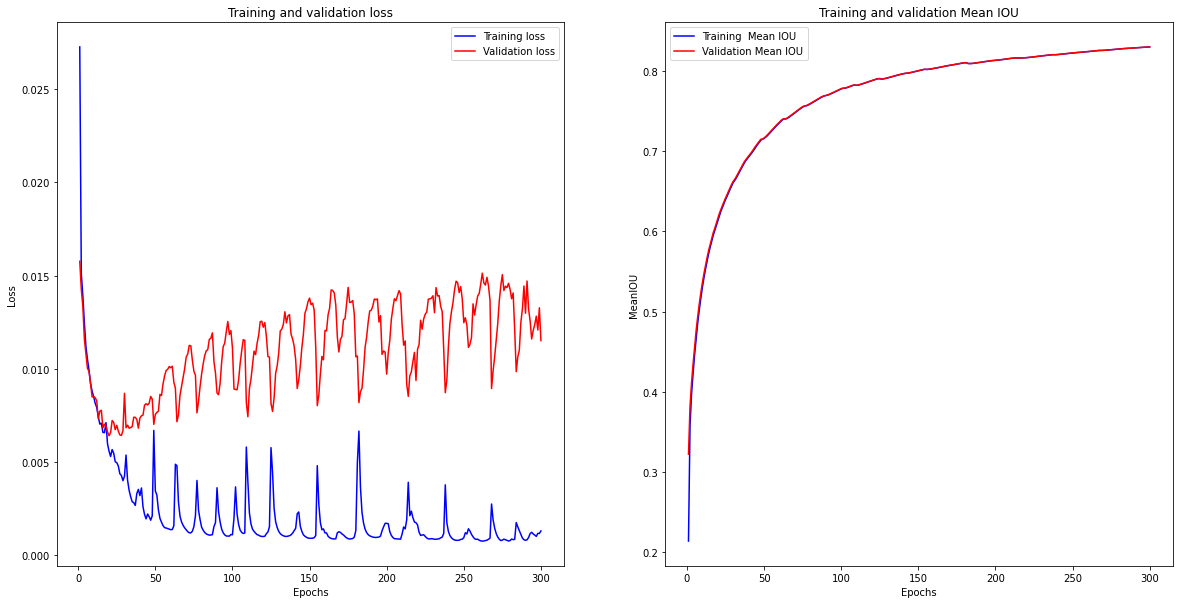

[[12355256.    53588.    91094.    19529.    72348.   126678.]
 [   73461.  6579596.   426081.    38553.    89306.   126881.]
 [  113461.   591278.  4397325.    28309.    53021.    86074.]
 [   17230.    50097.    41577.   238364.    41448.    14414.]
 [   58747.   210922.    60401.    40267.  2212423.    24029.]
 [  341601.   332284.   134505.    20375.    52004.  3555473.]]
0.92736346
0.7675642
0.7300736
0.43326068
0.7590006
0.7385206


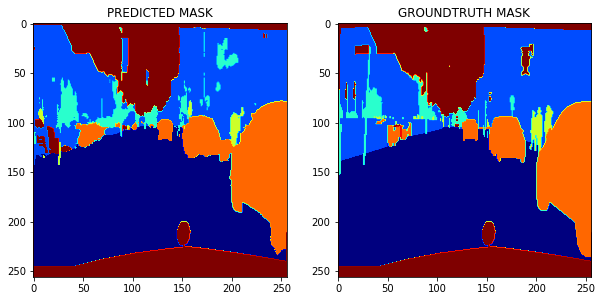

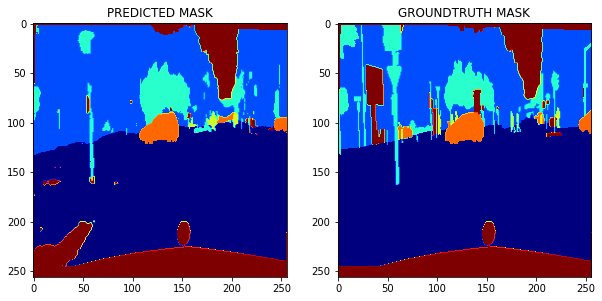

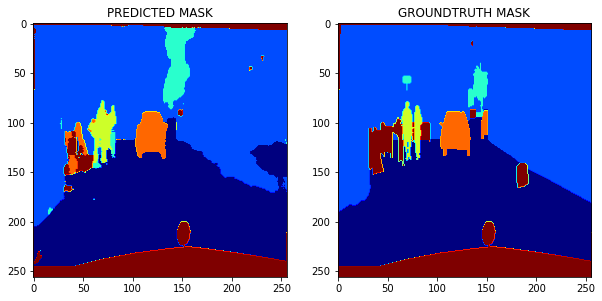

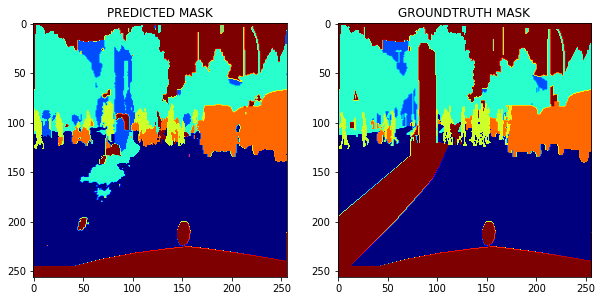

In [ ]:
display_and_save_metrics(history)
intersection_over_union(imgs_predicted,masks_test,CLASS_NUMBER)
display_traning_results(imgs_predicted,masks_test)